# EE P 590: Deep learning for Embedded Real-time Intelligence 

## Assignment 2: Deep learning operators & constructs (Due: 05/04 by 11:59 pm)

In [4]:
from eep590_utils import * 

# 0. Warm-up (25 points) 

###  Answer the following in your own words (read and understand the concepts, do not copy answers from the internet): 

**(a.) Why do deep neural networks typically outperform shallow networks?**

Because the deep networks can learn the more deeper information in the data. This can make the network to better understand the meaning contained in the data. For example, if using a multiple layer deep neural network to work on a face recognition job, the first layer in the network may focus on each pixels in the picture, the second layer may recognize the edges in the picture, the next layer may recognize the shapes in the picture combine by the edges. Maybe after a few layers, the model will recognize the eyes, mouth, and face. The really neural networks may not works as same as this example, but it gives a basic idea about why deep neural networks typically outperform shallow networks.

**(b.) What are the issues involved in training very deep neural networks from an optimization perspective?** 

1. Choose the reasonable learning rate
2. Find the global optimum rather than stuck on the local optimum
3. Deal with overfit

**(c.) What are the issues involved in training very deep neural networks from computation and memory perspective?** 

In the DNN, it is easy to create millions of parameters even train a simple DNN. Therefore, when training very deep neural networks, it is will store a huge number of parameters and need a huge number of parameter calculations. This requires larger memory and a good performance processor.

Another issue is the data transfer speed between processor and memory will impact the efficient of training.

**(d.) What is a validation dataset used for?**

The validation dataset is used for evaluate the performance of the model. It can give us a preview of how this model performance worked on the real data. It can also be used to check if the model is overfitting.

**(e.) The following learning rate plots show the loss of an algorithm versus time. Label each plot with one of these labels: (i) Low learning rate (ii) Optimal learning rate (iii) High learning rate (iv) Very high learning rate**

![model_training2](_model2.png)


Blue: Low learning rate 

Red: Optimal learning rate

Green: Hight learning rate

Yellow: very high learning rate

**(f.) What is the following activation function, and why is it used? How is it different from ReLU.**

![activation](activation.png)

This is Leaky ReLU function.

The difference between Leaky ReLU and ReLU is Leaky ReLU has a small slope for negative values, instead of altogether zero.

The benefit of Leaky ReLU: \
ReLU have a problem called "dying ReLU" The negative part of ReLU is equal to 0, and the slope of negative part is also equal to 0. If a neuron go to the negative part, it is unlikely for it to recover. Leaky ReLU fixes the “dying ReLU” problem, as it doesn’t have zero-slope parts.



**(g.) For a minibatch with mean M and variance V, what does batch normalization do?**

The batch normalization moralize the data in a mini-batch. For example, the data $x_i$ in mini-batch, the batch normalization will be:
$$ \hat x_i = \frac{x_i - M}{\sqrt{V+\sigma}}$$
where $\sqrt{V+\sigma}$ is standard deviation, and the $\sigma$ is the noise parameter in case the standard deviation to be 0.


**(h.) In one or more sentences, and using sketches as appropriate, contrast: AlexNet, VGG-Net, GoogleNet and ResNet. What was one defining characteristic of each?**

AlexNet: Using ReLU function and dropout function, Deeper and wider Neural Networks 

VGG-Net: Using the smaller 3x3 convolution, more deeper but less parameters.

GoogleNet: Use inception module. Split layers and multiple size of convolution

ResNet: Use residual connection, can train more deeper model.

**(j.) List 4 transformations that can be applied to images in a dataset to augment the dataset for CNN training.**

1. Cross Correlation
2. Convolution
3. Kernel
4. Filter

# 1. Cross correlation (15 points) 

Implement the 2D cross-correlation process in the cross_corr_2d function, which accepts an input tensor X and a kernel tensor K and returns an output tensor Y. Refer to lecture slides for the details. 

In [5]:
def cross_corr_2d(X, K):
  """
  Computes the 2D cross-correlation operation
  
  Inputs:
  - X: Input data 
  - K: The kernel tensor
    
  Returns:
  - Y: The output tensor after performing cross-correlation
  """

  # TODO: Implement the 2D cross-correlation here        #
  Y = torch.zeros((X.shape[0] - K.shape[0] + 1, X.shape[1] - K.shape[1] + 1))
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      Y[i, j] = (X[i:i + K.shape[0], j:j + K.shape[1]] * K).sum()
  #                             END OF YOUR CODE                              #

  return Y

In [6]:
# Example
X = torch.tensor([[0.0, 5.0, 8.0], [2.0, -1.0, 4.0], [4.0, 3.0, 7.0]])
K = torch.tensor([[5.0, -1.0], [3.0, 1.0]])

cross_corr_2d(X, K) 

tensor([[ 0., 18.],
        [26.,  7.]])

# 2. Spatial batch-norm (25 points)

One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is batch normalization which was proposed by [1].

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [1] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [1] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.


Knowing that batch normalization is a very useful technique for training deep fully-connected networks. Batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

**Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.**

**If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different imagesand different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.**

[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", ICML 2015](https://arxiv.org/abs/1502.03167)

### Reference

In [7]:
# batch normalization function, see reference [7] and made some changes. 

def batchnorm_forward(x, gamma, beta, bn_param):
  """
  Forward pass for batch normalization.

  Input:
  - x: Data of shape (N, D)
  - gamma: Scale parameter of shape (D,)
  - beta: Shift paremeter of shape (D,)
  - bn_param: Dictionary with the following keys:
    - mode: 'train' or 'test'; required
    - eps: Constant for numeric stability
    - momentum: Constant for running mean / variance.
    - running_mean: Array of shape (D,) giving running mean of features
    - running_var Array of shape (D,) giving running variance of features

  Returns a tuple of:
  - out: of shape (N, D)
  - cache: A tuple of values needed in the backward pass
  """
  mode = bn_param['mode']
  eps = bn_param.get('eps', 1e-5)
  momentum = bn_param.get('momentum', 0.9)

  N, D = x.shape
  running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
  running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

  out, cache = None, None
  if mode == 'train':
    sample_mean = np.mean(x, axis=0)
    sample_var = np.var(x, axis=0)

    # Normalization followed by Affine transformation
    x_normalized = (x - sample_mean)/np.sqrt(sample_var + eps)
    out = gamma*x_normalized + beta

    # Estimate running average of mean and variance to use at test time
    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    # Cache variables needed during backpropagation
    cache = (x, sample_mean, sample_var, gamma, beta, eps, x_normalized)

  elif mode == 'test':
    # normalize using running average
    x_normalized = (x - running_mean)/np.sqrt(running_var + eps)

    # Learned affine transformation
    out = gamma*x_normalized + beta

  # Store the updated running means back into bn_param
  bn_param['running_mean'] = running_mean
  bn_param['running_var'] = running_var

  return out, cache

def batchnorm_backward(dout, cache):
  """
  Backward pass for batch normalization.

  Inputs:
  - dout: Upstream derivatives, of shape (N, D)
  - cache: Variable of intermediates from batchnorm_forward.

  Returns a tuple of:
  - dx: Gradient with respect to inputs x, of shape (N, D)
  - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
  - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
  """
  #Unpack cache variables
  x, sample_mean, sample_var, gamma, beta, eps, x_normalized = cache


  # See derivations above for dgamma, dbeta and dx
  dgamma = np.sum(dout * x_normalized, axis=0)
  dbeta = np.sum(dout, axis=0)

  m = x.shape[0]
  t = 1./np.sqrt(sample_var + eps)

  dx = (gamma * t / m) * (m * dout - np.sum(dout, axis=0)
        - t**2 * (x-sample_mean) * np.sum(dout*(x - sample_mean), axis=0))

  return dx, dgamma, dbeta

## "spatial_batchnorm_forward" and "spatial_batchnorm_backward"

In [8]:
def spatial_batchnorm_forward(x, gamma, beta, bn_param):
  """
  Computes the forward pass for spatial batch normalization.
  
  Inputs:
  - x: Input data of shape (N, C, H, W)
  - gamma: Scale parameter, of shape (C,)
  - beta: Shift parameter, of shape (C,)
  - bn_param: Dictionary with the following keys:
    - mode: 'train' or 'test'; required
    - eps: Constant for numeric stability
    - momentum: Constant for running mean / variance. momentum=0 means that
      old information is discarded completely at every time step, while
      momentum=1 means that new information is never incorporated. The
      default of momentum=0.9 should work well in most situations.
    - running_mean: Array of shape (D,) giving running mean of features
    - running_var Array of shape (D,) giving running variance of features
    
  Returns a tuple of:
  - out: Output data, of shape (N, C, H, W)
  - cache: Values needed for the backward pass
  """
  out, cache = None, None

  # TODO: Implement the forward pass for spatial batch normalization.         #
  #                                                                           #
  # HINT: You can implement spatial batch normalization using the vanilla     #
  # version of batch normalization.                             #
  N, C, H, W = x.shape
  x_new = np.swapaxes(x, 0, 1)
  out, cache = batchnorm_forward(x_new.reshape(C,-1).T, gamma, beta, bn_param)
  out = out.T.reshape(C,N,H,W).swapaxes(0,1)
  
  return out, cache


def spatial_batchnorm_backward(dout, cache):
  """
  Computes the backward pass for spatial batch normalization.
  
  Inputs:
  - dout: Upstream derivatives, of shape (N, C, H, W)
  - cache: Values from the forward pass
  
  Returns a tuple of:
  - dx: Gradient with respect to inputs, of shape (N, C, H, W)
  - dgamma: Gradient with respect to scale parameter, of shape (C,)
  - dbeta: Gradient with respect to shift parameter, of shape (C,)
  """
  dx, dgamma, dbeta = None, None, None

  # TODO: Implement the backward pass for spatial batch normalization.        #
  #                                                                           #                            #
  N, C, H, W = dout.shape
  dx, dgamma, dbeta =  batchnorm_backward(dout.swapaxes(0,1).reshape(C,-1).T, cache)
  dx = dx.T.reshape(C,N,H,W).swapaxes(0,1)

  return dx, dgamma, dbeta

## (a.) Forward 
Implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [9]:
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [10.31283758 10.60485745  9.5885517 ]
  Stds:  [4.42807216 4.42667859 4.65742152]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 3.10862447e-16  2.49800181e-16 -4.44089210e-17]
  Stds:  [0.99999974 0.99999974 0.99999977]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [6. 7. 8.]
  Stds:  [2.99999923 3.99999898 4.99999885]


In [10]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [ 0.04646723  0.00909665  0.04735761 -0.00717071]
  stds:  [1.00713064 0.98127866 1.02749717 1.01244634]


## (b.) Backward 
Implement the backward pass for spatial batch normalization in the function `spatial_batchnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [11]:
def rel_error(a,b):
    temp = np.abs(a-b)/(1e-8 + np.abs(a) + np.abs(b)) 
    return np.sum(temp)

In [12]:
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print ('dx error: ', rel_error(dx_num, dx))
print ('dgamma error: ', rel_error(da_num, dgamma))
print ('dbeta error: ', rel_error(db_num, dbeta))

dx error:  8.083011461753806e-08
dgamma error:  9.385646875700735e-12
dbeta error:  8.360299601539569e-11


# 3. Image gradients (40 points)

In this section we'll introduce the ImageNet dataset and a deep CNN that has been pretrained on this dataset. You will use this pretrained model to compute gradients with respect to images, and use these image gradients to produce class saliency maps and adversarial images. 

When training a model, we define a loss function which measures our current unhappiness with the model's performance; we then use backpropagation to compute the gradient of the loss with respect to the model parameters, and perform gradient descent on the model parameters to minimize the loss.

Here we will do something slightly different. We will start from a convolutional neural network model which has been pretrained to perform image classification on the ImageNet dataset. We will use this model to define a loss function which quantifies our current unhappiness with our image, then use backpropagation to compute the gradient of this loss with respect to the pixels of the image. We will then keep the model fixed, and perform gradient descent on the image to synthesize a new image. 

In [13]:
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import random

from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

### Helper functions

Our pretrained model was trained on images that had been preprocessed by subtracting the per-color mean and dividing by the per-color standard deviation. We define a few helper functions for performing and undoing this preprocessing. You don't need to do anything in this cell.


In [14]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=_MEAN.tolist(),
                    std=_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / _STD).tolist()),
        T.Normalize(mean=(-_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

### Pretrained Model
For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [2], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all image generation experiments on CPU.

[2] [Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016](https://arxiv.org/abs/1602.07360)

In [15]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

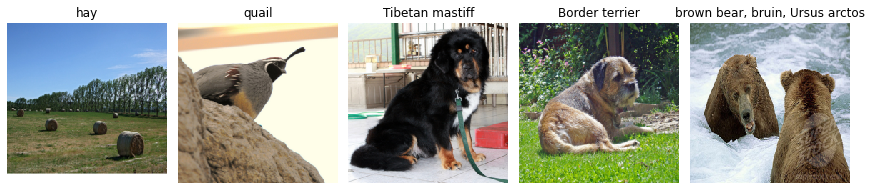

In [16]:
def load_imagenet_val(num=None):
    """Load a handful of validation images from ImageNet.
    Inputs:
    - num: Number of images to load (max of 25)
    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    imagenet_fn = 'data/imagenet_val_25.npz'
    if not os.path.isfile(imagenet_fn):
      print('file %s not found' % imagenet_fn)
    f = np.load(imagenet_fn, allow_pickle = True)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names

X, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

## (a.) Saliency Maps

Using the pretrained model, we will compute class saliency maps as described in Section 3.1 of [3].

A saliency map tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(3, H, W)` then this gradient will also have shape `(3, H, W)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

[3] [Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014.](https://arxiv.org/abs/1312.6034)

In [17]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y)
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    
    model.eval()
    
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y)
    saliency = None
    scores = model(X_var)

    scores_arr = scores.gather(1, y_var.view(-1, 1)).squeeze()
    sum_scores = torch.sum(scores_arr)

    sum_scores.backward()
    
    saliency = X_var.grad.data.abs().max(dim=1)[0].squeeze()
    return saliency

/Users/qingchuanhou/opt/anaconda3/envs/main/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


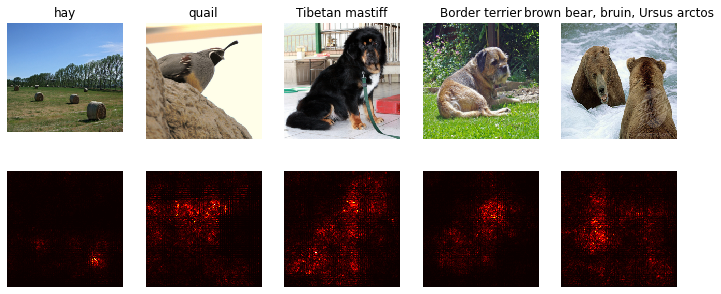

In [18]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

### Hint: Use gather() in pytorch 



In [19]:
# Example of using gather to select one entry from each row in PyTorch
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

tensor([[-0.6107, -1.9019, -0.0892,  0.0654,  0.5753],
        [ 0.1671, -0.1746, -0.0837,  0.5247, -0.6583],
        [-0.1033, -0.9724,  1.0654, -0.2615, -0.5748],
        [-0.4431,  0.3884, -1.5094,  0.4419,  1.1748]])
tensor([1, 2, 1, 3])
tensor([-1.9019, -0.0837, -0.9724,  0.4419])


### Sample expected output: 

![saliency maps](sal_maps.png)

## (b.) Adversarial Images 
We can also use image gradients to generate "adversarial images" as discussed in [4]. Given an image and a target class, we can perform gradient ascent over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate adversarial images.

[4] [Szegedy et al, "Intriguing properties of neural networks", ICLR 2014](https://arxiv.org/abs/1312.6199)

In [20]:
def make_adv_image(X, target_y, model):
    """
    Generate an adversarial image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_adv: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our adversarial image to the input image, and wrap it in a Variable.
    X_adv = X.clone()
    X_adv_var = Variable(X_adv, requires_grad=True)
    
    learning_rate = 1
    ##############################################################################
    # TODO: Generate a adversarial image X_adv that the model will classify as #
    # the class target_y. You should perform gradient ascent on the score of the #
    # target class, stopping when the model is fooled.                           #
    # Hint: When computing an update step, first normalize the gradient:         #
    #   dX = learning_rate * g / ||g||_2                                         #
    #                                                                            #
    # You should write a training loop.                                          #
    #                                                                            #
    # HINT: For most examples, you should be able to generate a adv image    #
    # in fewer than 100 iterations of gradient ascent.                           #
    # You can print your progress over iterations to check your algorithm.       #
    ##############################################################################
    max_iter = 100
    for i in range(max_iter):
        scores = model(X_adv_var)
        y_pred = torch.argmax(scores, axis = 1)
        correct_class_score = scores[:,target_y]

        if y_pred == target_y:
            print('The model is fooled')
            break

        print(f'Iteration {i}: target score {correct_class_score.item()}, max score {y_pred.item()}')
    
        correct_class_score.backward()
        with torch.no_grad():
            grad = X_adv_var.grad.data * learning_rate/(torch.sum(X_adv_var.grad.data)**2)
            X_adv_var += grad
        
        X_adv_var.requires_grad_()

    return X_adv

In [21]:
idx = 0
target_y = 6

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_adv = make_adv_image(X_tensor[idx:idx+1], target_y, model)

scores = model(Variable(X_adv))
assert target_y == scores.data.max(1)[1][0], 'The model is not fooled!'

Iteration 0: target score 5.213545322418213, max score 958
Iteration 1: target score 10.806939125061035, max score 958


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Iteration 2: target score 18.80084228515625, max score 344
Iteration 3: target score 22.42776870727539, max score 344
Iteration 4: target score 25.054473876953125, max score 344
Iteration 5: target score 26.982820510864258, max score 344
Iteration 6: target score 28.700698852539062, max score 344
Iteration 7: target score 30.220630645751953, max score 344
The model is fooled


After generating a fooling image, run the following cell to visualize the original image, the fooling image, as well as the difference between them.

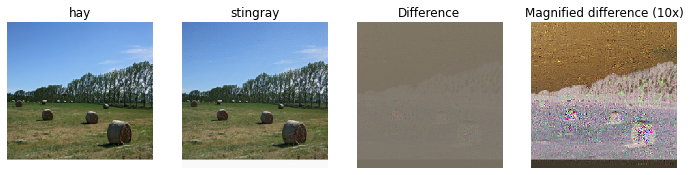

In [22]:
X_fooling = deprocess(X_adv.clone())
X_fooling_np = np.asarray(X_fooling).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
X_fooling_pre = preprocess(Image.fromarray(X_fooling_np))
diff = np.asarray(deprocess(X_fooling_pre - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling_pre - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

### Sample expected output: 

![Adversarial Images](adv_img.png)

# 4. RNN: Text-to-tag classification (40 points)


## Task

Given a sentence, give a tag to each word. 

```
Richard  lives  in  Seattle
B-PER     O     O   B-LOC 
```

(Note: Here B-PER means person, and B-LOC means location)

**We have provided the dataset and the partial codes, your task is to complete all the required modules such that it works end-to-end. You need to complete the following steps:** 

1. **Process the dataset** Run the following script

```
python3 process_dataset.py
```

It should extract the sentences and labels from the dataset, split it into train/val/test and save it in a convenient format for our model. (for reference, see `data/example/`)

_Debug_ If you get some errors, check that you downloaded all the right files and it is saved in the right directories/paths. If you have issues with encoding, try running the script with python 2.7.


2. **Build** vocabularies and parameters for your dataset by running

```
python3 build_vocab.py --data_dir data/new_data
```

It should write vocabulary files `words.txt` and `tags.txt` containing the words and tags in the dataset. It should also save a `dataset_params.json` with some extra information.

3. **Your first experiment** We created a `base_model` directory for you under the `experiments` directory. It contains a file `params.json` which sets the hyperparameters for the experiment. It looks like

```json
{
  "learning_rate": 1e-3,
  "batch_size": 5,
  "num_epochs": 2
}
```

For every new experiment, you will need to create a new directory under `experiments` with a `params.json` file.

3. **Train** your experiment. Simply run

```
python3 train.py --data_dir data/new_data --model_dir experiments/base_model
```

It should instantiate a model and train it on the training set following the hyperparameters specified in `params.json`. It should also evaluate some metrics on the development set.

4. **Your first hyperparameters search** We created a new directory `learning_rate` in `experiments` for you. Now, run

```
python3 search_hyperparams.py --data_dir data/new_data --parent_dir experiments/learning_rate
```

It should train and evaluate a model with different values of learning rate defined in `search_hyperparams.py` and create a new directory for each experiment under `experiments/learning_rate/`.

5. **Display the results** of the hyperparameters search in a nice format

```
python3 display_results.py --parent_dir experiments/learning_rate
```

6. **Evaluation on the test set** Once you've run many experiments and selected your best model and hyperparameters based on the performance on the development set, you can finally evaluate the performance of your model on the test set. Run

```
python3 evaluate.py --data_dir data/new_data --model_dir experiments/base_model
```

Once you get something working for the dataset, feel free to edit any part of the code to suit your own needs.



# 5. References & Misc. (15 points) 

**(a.) How many hours (approx) did you spend on this assignment totally? Document and explain your journey, including the issues/challenges you faced (both technical and non-technical).**

**(b.) Cite all the resources and references you consulted to complete this assignment.** 

I think I spend more than 40 hours on this assignment. The main difficulty is understanding some concepts, and once the concepts are understood, there is nothing particularly difficult about the implementation of the code, just looking up the functions I need. So most of time was doing research on some concepts.

**Reference**

[1] Deep Neural Networks: https://stats.stackexchange.com/questions/222883/why-are-neural-networks-becoming-deeper-but-not-wider

[2] Optimization: https://towardsdatascience.com/neural-network-optimization-7ca72d4db3e0

[3] DNN Memory: https://www.graphcore.ai/posts/why-is-so-much-memory-needed-for-deep-neural-

[4] ReLU: https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7

[5] Batch Normalization: https://www.youtube.com/watch?v=dXB-KQYkzNU

[6] Attention: https://towardsdatascience.com/attention-in-neural-networks-e66920838742

[7] Training Deep Neural Networks with Batch Normalization: https://zaffnet.github.io/batch-normalization